# Week 5

**`Agent::model-based::persistence`**
- softmax policy

**`Agent::model-based::VAR`**
- softmax policy
- binary trader

**`Agent::model-based::RNN`**
- softmax policy
- binary trader

In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# data provider
from qtrader.envs.data_loader import Finance
# pandas.DataFrame cleaner
from qtrader.utils.pandas import clean
# rolling data generator
from qtrader.utils import rolling2d
# trading environment
from qtrader.envs import TradingEnv
# agent base class
from qtrader.agents.base import Agent
# NumPy implementation of Softmax
from qtrader.utils.numpy import softmax

# YAML parser
import yaml

# scientific programming
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR
import tensorflow as tf

# # visualization
import matplotlib.pyplot as plt

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_5.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"training start date: {config['training_start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")

start date: 2017-01-01
training start date: 2015-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'GS', 'MMM']


## `PersistenceAgent`

Model-based **persistence** agent, acting based on last observation
(i.e returns at t-1), using softmax function.

In [4]:
class PersistenceAgent(Agent):
    """Model-based persistence agent,
    act based on last observation (t-1)
    only, using softmax function."""

    _id = 'persistence'

    def __init__(self):
        pass

    def act(self, observation):
        _returns = observation['returns']
        if _returns.isnull().any():
            # random sample
            _values = pd.Series(np.random.uniform(0, 1, len(_returns)),
                                index=_returns.index,
                                name=_returns.name)
        else:
            # one step look back
            _values = _returns
        return softmax(_values)

In [5]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 start_date=config['start_date'],
                 csv=config['csv_file_prices'],
                 cash=False)
# initialize agent
agent = PersistenceAgent()
# execute environment
rewards, actions = agent.fit(env)
# track record
print(f"score: {sum(rewards[0])}")
# pandas DataFrame actions
actions_df = pd.DataFrame(actions[0])

score: 0.15549402563016787


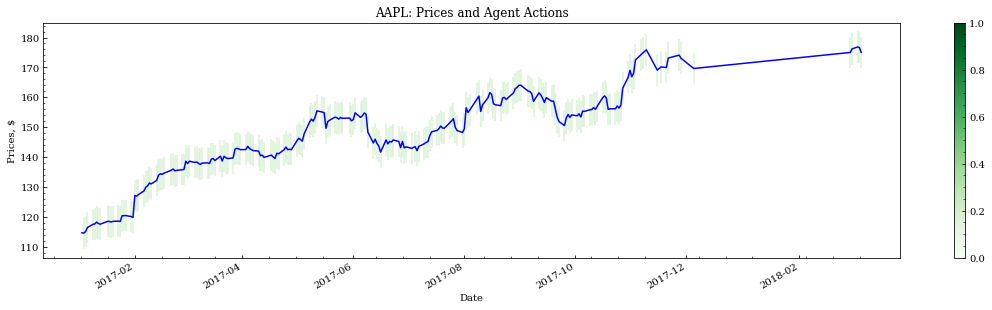

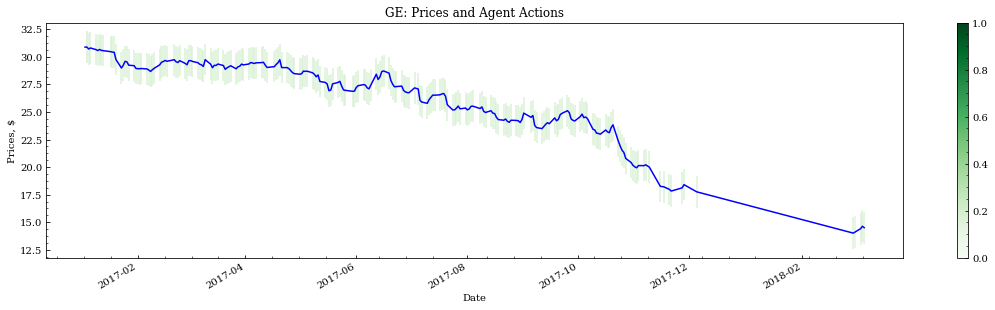

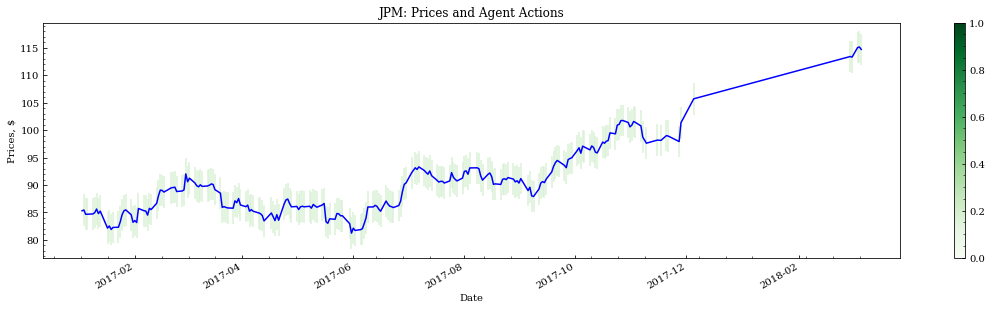

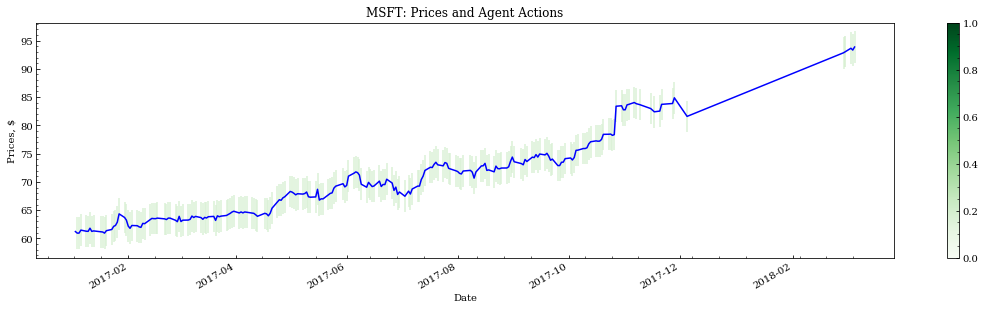

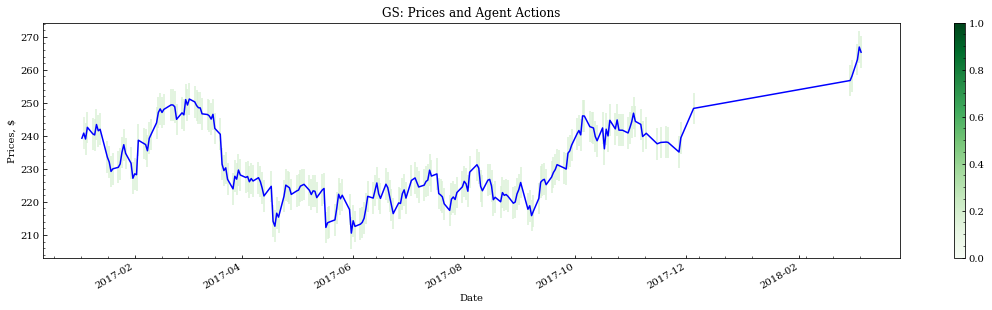

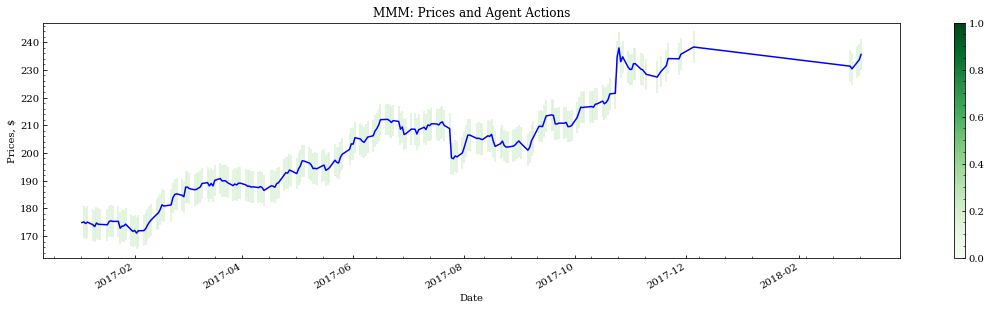

In [6]:
for asset in env.universe:
    fig, ax = plt.subplots(figsize=(19.2, 4.8))
    env._prices[asset].plot(ax=ax)
    sc = ax.scatter(env._prices[asset].iloc[1:].index,
                    env._prices[asset].iloc[1:].values,
                    c=actions_df[asset].values,
                    cmap=plt.cm.Greens,
                    marker='|',
                    s=1000,
                    vmin=0,
                    vmax=1)
    ax.set(ylabel='Prices, $', title='%s: Prices and Agent Actions' % asset)
    fig.colorbar(sc, ax=ax)

## `VARAgent`

Model-based Vector-Autoregressive (**VAR**) agent, trained offline on a historic dataset.

In [7]:
class VARAgent(Agent):
    """Model-based VAR agent,
    trained offline on a
    historic dataset."""

    _id = 'VAR'

    def __init__(self, df, max_order=15, policy='softmax'):
        # initialize VAR model
        self.model = VAR(df)
        # fit model
        self.model = self.model.fit(maxlags=max_order,
                                    ic='aic')
        # memory used to cache observations
        self.memory = pd.DataFrame(columns=df.columns)
        # policy
        self.policy = 'softmax'
    
    def observe(self, observation, action, reward, done, next_observation):
        self.memory.append([observation['returns'],
                            next_observation['returns']])
    

    def act(self, observation):
        _returns = observation['returns']
        if len(self.memory) == 0:
            # random sample
            _values = np.random.uniform(0, 1, self.model.coefs.shape[-1])
        else:
            # forecast one step returns
            _values = self.model.forecast(self.memory.dropna().values, 1)[0]
        # softmax policy
        if self.policy == 'softmax':
            # to pandas.Series
            _action = pd.Series(_values,
                                index=_returns.index,
                                name=_returns.name)
            return softmax(_action)
        # LONG best stock policy
        elif self.policy == 'best':
            # one-hot vector
            _action = np.zeros_like(_values).ravel()
            _action[np.argmax(_values)] = 1.0
            # to pandas.Series
            _action = pd.Series(_action,
                                index=_returns.index,
                                name=_returns.name)
            return _action

In [8]:
# fetch historic data
data = clean(Finance.Returns(config['tickers'],
                             config['training_start_date'],
                             config['start_date'],
                             freq=config['freq'],
                             csv=config['csv_file_returns']))
# initialize agent
agent = VARAgent(data)
# execute environment
rewards, actions = agent.fit(env)
# track record
print(f"score: {sum(rewards[0])}")
# pandas DataFrame actions
actions_df = pd.DataFrame(actions[0])

/Users/alpha/Developer/qtrader/.env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


score: 0.14355179861855158


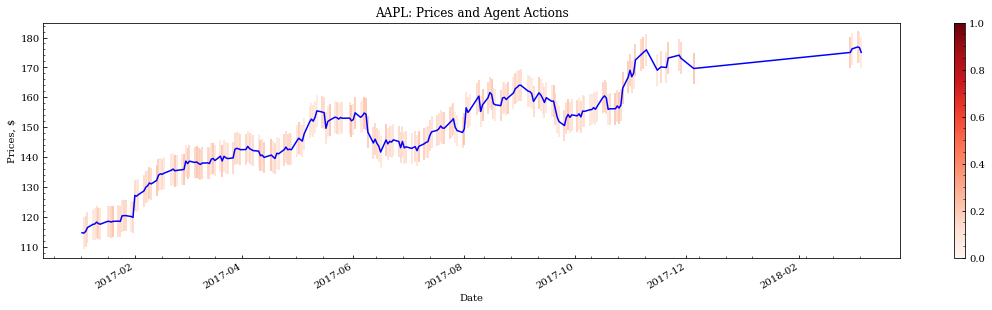

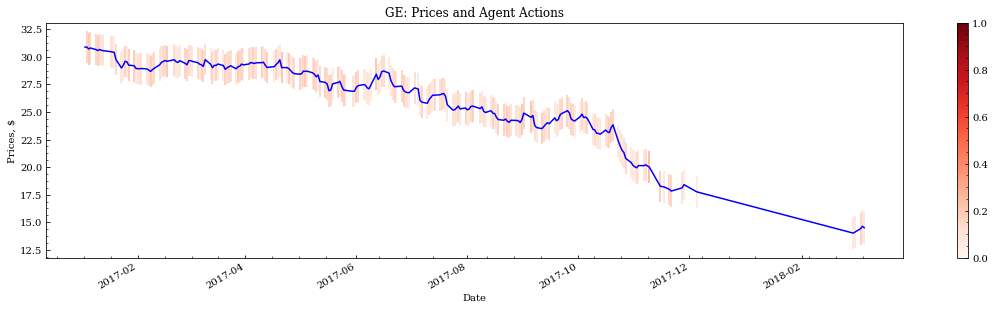

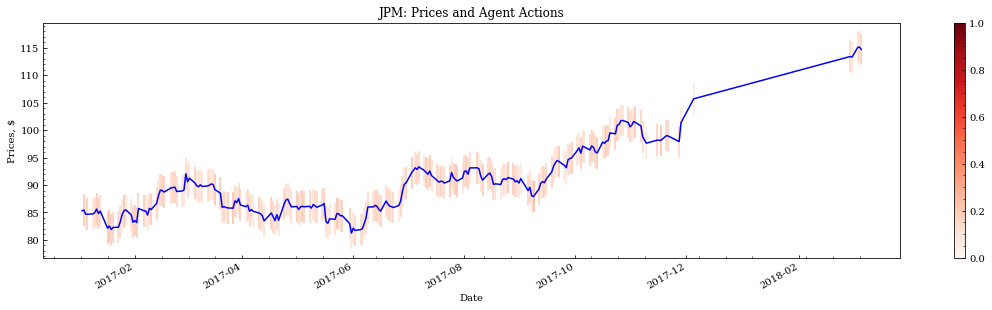

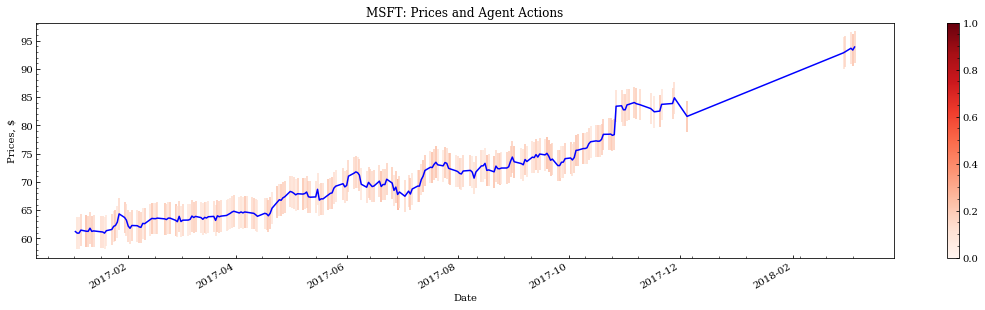

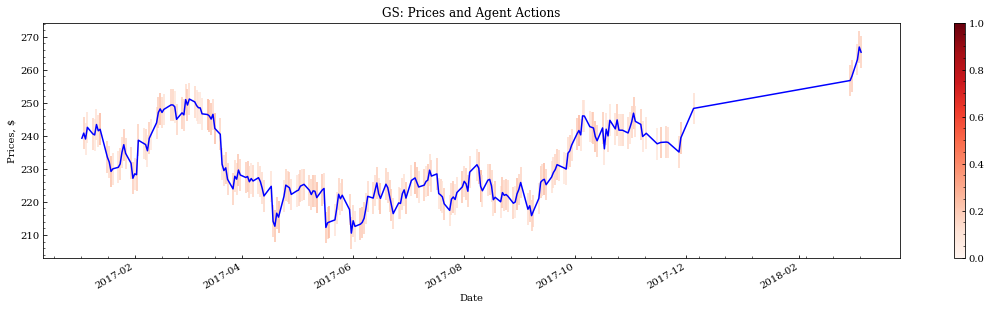

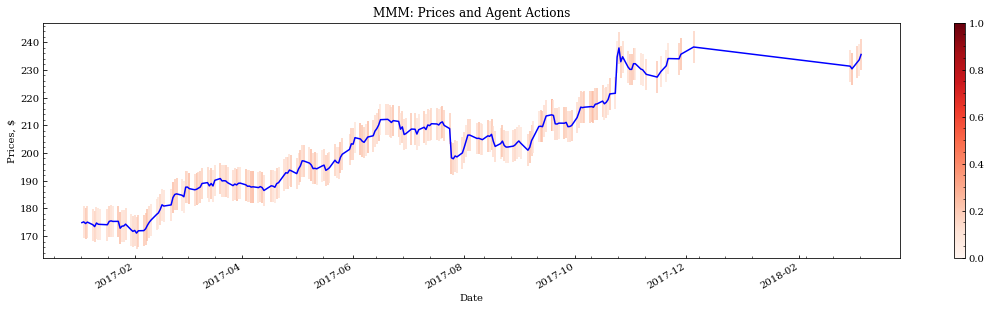

In [9]:
for asset in env.universe:
    fig, ax = plt.subplots(figsize=(19.2, 4.8))
    env._prices[asset].plot(ax=ax)
    sc = ax.scatter(env._prices[asset].iloc[1:].index,
                    env._prices[asset].iloc[1:].values,
                    c=actions_df[asset].values,
                    cmap=plt.cm.Reds,
                    marker='|',
                    s=1000,
                    vmin=0,
                    vmax=1)
    ax.set(ylabel='Prices, $', title='%s: Prices and Agent Actions' % asset)
    fig.colorbar(sc, ax=ax)

## `RNNAgent`

Model-based Recurrent Neural Network (**RNN**) agent,
trained offline on a historic dataset.

In [10]:
class RNNAgent(Agent):
    """Model-based RNN agent,
    trained offline on a
    historic dataset."""

    _id = 'RNN-GRU'

    def __init__(self, df, hidden_units=64, policy='softmax',
                 batch_size=32, epochs=50):
        # get dimensions
        observation_size = action_size = len(df.columns)
        # initialize model
        self.model = self.build_model(observation_size,
                                      action_size,
                                      hidden_units)
        # prepare data
        X, y = self.Xy(df, window=1)
        # fit model
        self.model.fit(X, y,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=0)
        # memory used to cache observations
        self.memory = pd.DataFrame(columns=df.columns)
        # polict
        self.policy = policy
    
    def build_model(self,
                    observation_size,
                    action_size,
                    hidden_units):
        # input node
        X = tf.keras.layers.Input(
            shape=(1, observation_size),
            name='X'
        )
        # recurrent layer
        rnn = tf.keras.layers.GRU(
            hidden_units,
            activation='relu',
            name='rnn'
        )(X)
        # fully-connected layer
        y = tf.keras.layers.Dense(
            action_size,
            name='y'
        )(rnn)
        # model
        model = tf.keras.models.Model(X, y)
        # compilation
        model.compile(optimizer='rmsprop',
                      loss='mse')
        # print summary
        model.summary()
        return model

    def Xy(self, df, window):
        # rolling data
        tmp = rolling2d(clean(df), window + 1)
        # feature matrix
        X = tmp[:, :-1, :]
        # target matrix
        y = tmp[:, -1, :]
        return X, y   

    def act(self, observation):
        # fetch historic returns
        _returns = observation['returns']
        # sth went wrong
        if np.isnan(np.sum(_returns)):
            # random sample
            _values = np.random.uniform(0, 1, self.model.input.shape.as_list()[-1])
        # normal case
        else:
            # forecast one step ahead
            _values = self.model.predict(_returns.values.reshape(1, 1, -1))[0]
        # std went wrong
        if np.isnan(np.sum(_values)):
            # random sample
            _values = np.random.uniform(0, 1, self.model.input.shape.as_list()[-1])
        # softmax policy
        if self.policy == 'softmax':
            # to pandas.Series
            _action = pd.Series(_values,
                                index=_returns.index,
                                name=_returns.name)
            return softmax(_action)
        # LONG best stock policy
        elif self.policy == 'best':
            # one-hot vector
            _action = np.zeros_like(_values).ravel()
            _action[np.argmax(_values)] = 1.0
            # to pandas.Series
            _action = pd.Series(_action,
                                index=_returns.index,
                                name=_returns.name)
            return _action

In [11]:
# fetch historic data
data = clean(Finance.Returns(config['tickers'],
                             config['training_start_date'],
                             config['start_date'],
                             freq=config['freq'],
                             csv=config['csv_file_returns']))
# initialize agent
agent = RNNAgent(data)
# execute environment
rewards, actions = agent.fit(env)
# track record
print(f"score: {sum(rewards[0])}")
# pandas DataFrame actions
actions_df = pd.DataFrame(actions[0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1, 6)              0         
_________________________________________________________________
rnn (GRU)                    (None, 64)                13632     
_________________________________________________________________
y (Dense)                    (None, 6)                 390       
Total params: 14,022
Trainable params: 14,022
Non-trainable params: 0
_________________________________________________________________
score: 0.15271947583578183


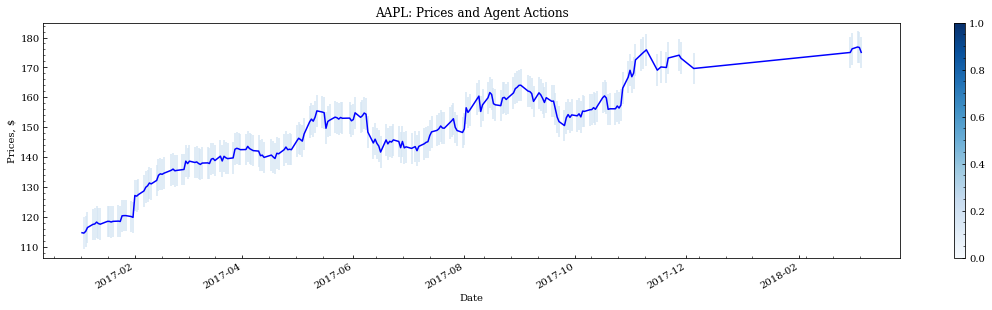

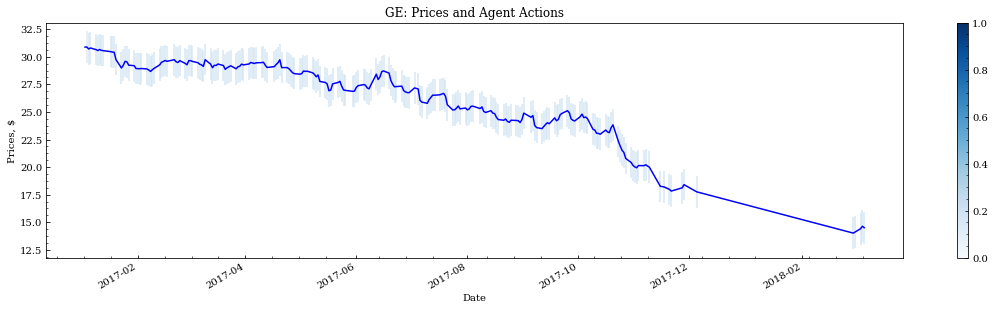

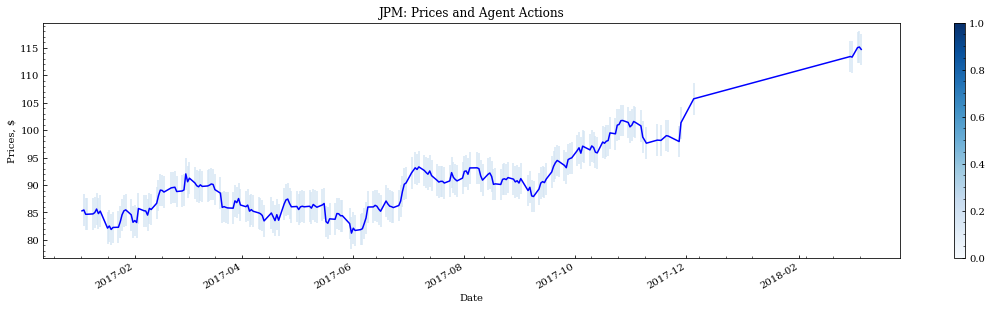

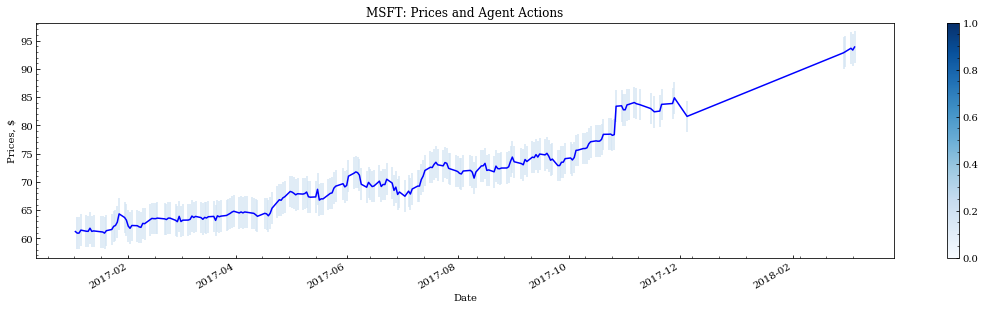

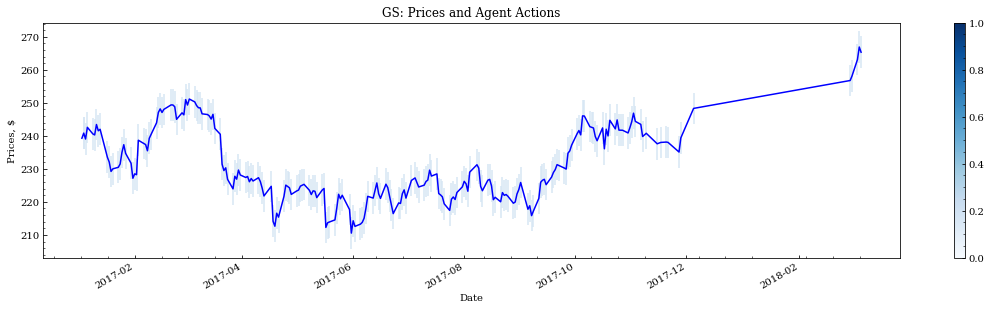

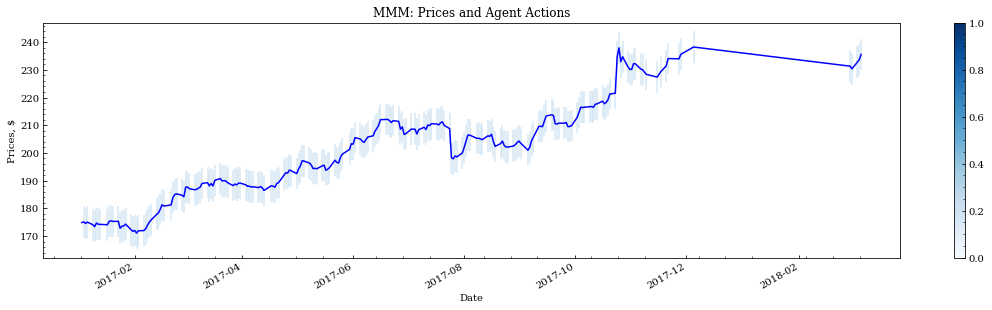

In [12]:
for asset in env.universe:
    fig, ax = plt.subplots(figsize=(19.2, 4.8))
    env._prices[asset].plot(ax=ax)
    sc = ax.scatter(env._prices[asset].iloc[1:].index,
                    env._prices[asset].iloc[1:].values,
                    c=actions_df[asset].values,
                    cmap=plt.cm.Blues,
                    marker='|',
                    s=1000,
                    vmin=0,
                    vmax=1)
    ax.set(ylabel='Prices, $', title='%s: Prices and Agent Actions' % asset)
    fig.colorbar(sc, ax=ax)